In [26]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
current_dir = os.getcwd()
results = pd.read_csv(current_dir + '/MISA/results/mosei_MISA_confidNet_mse_epoch(10)_test_results.csv')

In [3]:
'''confidNet results
columns: ['id', 'input_text', 'emo_label', 'predict', 'confid_loss', 'target_tcp', 'predict_tcp', ...]
labels: ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
'''
results.head()

,id,input_text,emo_label,predict,confid_loss,target_tcp,predict_tcp,predict_tcp_text_removed,predict_tcp_video_removed,predict_tcp_audio_removed
0,-6rXp3zJ3kc[1],very aware of many people are not until they g...,[0. 1. 0. 0. 0. 0.],[0.55662537 0.38589606 0.3532847 0.32799417 0...,0.041736,0.385896,0.429259,0.009789,0.946766,0.060735
1,-AUZQgSxyPQ[0],the perfect soul mate to the spot therapy brus...,[0. 0. 0. 0. 0. 1.],[0.7481889 0.23310995 0.18807708 0.17202565 0...,0.041736,0.256660,0.483656,0.000666,0.954069,0.308022
2,-6rXp3zJ3kc[2],so the answer to the question can i contribute...,[0. 1. 0. 0. 0. 0.],[0.5145242 0.36878633 0.3164015 0.21287923 0...,0.041736,0.368786,0.403934,0.000339,0.663066,0.026535
3,-MeTTeMJBNc[3],picture maybe you could find a picture of the ...,[1. 0. 0. 1. 0. 0.],[0.58545935 0.32975513 0.27381423 0.2885348 0...,0.041736,0.436997,0.440424,0.000013,0.171476,0.126317
4,-RfYyzHpjk4[3],time you can use it for personal use family fr...,[1. 0. 1. 0. 1. 0.],[0.56471854 0.3299958 0.22099274 0.18321313 0...,0.041736,0.302346,0.390663,0.000084,0.978621,0.010942


In [4]:
print(len(results))

4654


In [5]:
results['emo_label'].loc[lambda x: x =='[0. 0. 0. 0. 0. 0.]'].count()

701

In [6]:
print(np.mean(results['confid_loss']))

0.04436766662641708


In [7]:
text_is_noise = results[results['predict_tcp_text_removed'] > results['predict_tcp']]
audio_is_noise = results[results['predict_tcp_video_removed'] > results['predict_tcp']]
video_is_noise = results[results['predict_tcp_audio_removed'] > results['predict_tcp']]

In [8]:
# Modality noise counts with no label rows dropped
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  4654
Textual noise counts:  578
Visual noise counts:  180
Audio noise counts:  3652


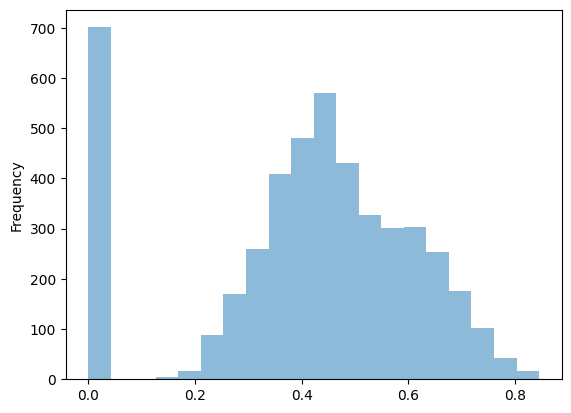

In [9]:
ax = results['target_tcp'].plot.hist(bins=20, alpha=0.5)

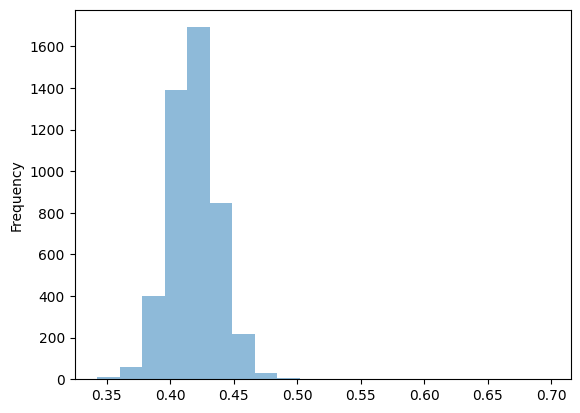

In [10]:
ax = results['predict_tcp'].plot.hist(bins=20, alpha=0.5)

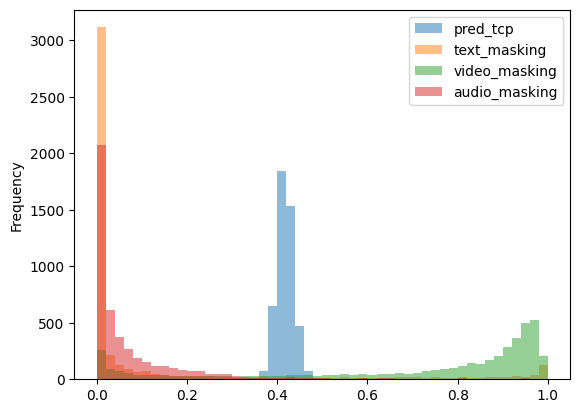

In [25]:
df = pd.DataFrame({'pred_tcp': results['predict_tcp'], 'text_masking': results['predict_tcp_text_removed'], 'video_masking': results['predict_tcp_video_removed'], 'audio_masking': results['predict_tcp_audio_removed']})
ax = df.plot.hist(bins=50, alpha=0.5)

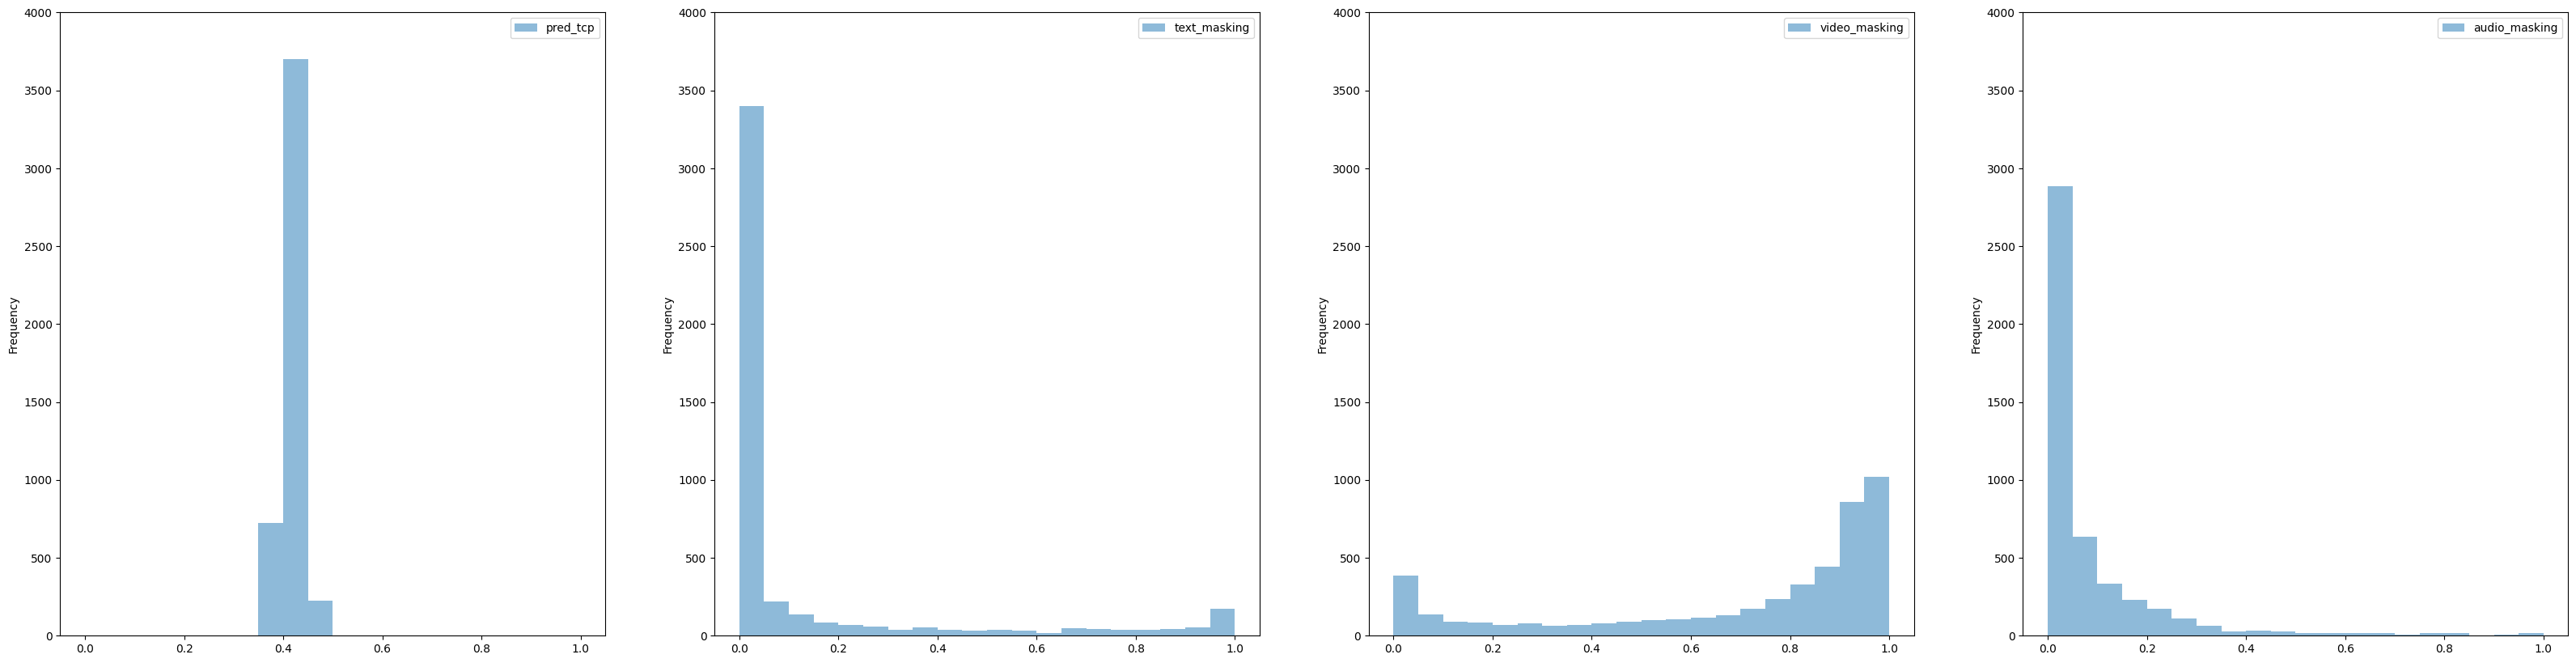

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
m=0
for i in range(4):
    df.plot.hist(column=df.columns[m], bins=20, ax=ax[i], alpha=0.5, ylim=(0, 4000))
    m+=1

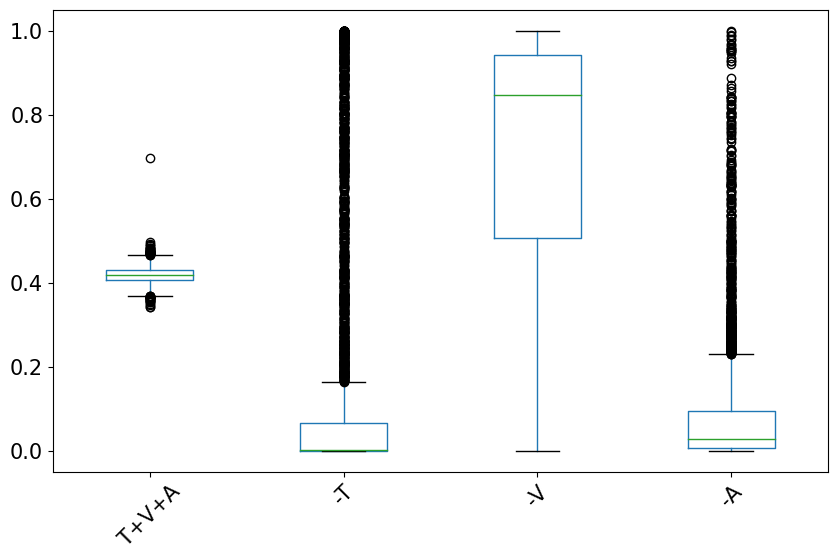

In [18]:
df = pd.DataFrame({'T+V+A': results['predict_tcp'], '-T': results['predict_tcp_text_removed'], '-V': results['predict_tcp_video_removed'], '-A': results['predict_tcp_audio_removed']})
boxplot = df.boxplot(column=['T+V+A', '-T', '-V', '-A'], grid=False, fontsize=15, rot=45, figsize=(10,6))

In [ ]:
# Frequency of top-1 confidence for each modalities
top_1_confidence = df.Dataframe({
    
})

In [3]:
'''DKT-TCP results
columns
    id: id of the video
    input_sentence: actual text input
    label: ground truth label list
    prediction: predicted label list
    confidence: confidence of the prediction
    confidence-t: confience while removing the text modality
    confidence-a: confience while removing the audio modality
    confidence-v: confience while removing the video modality
labels
    0: happiness
    1: sadness
    2: anger
    3: fear
    4: disgust
    5: surprise
'''
results.head()

,id,confid_loss,target_tcp,predict_tcp,emo_label,predict,input_text
0,-6rXp3zJ3kc[1],0.041736,0.385896,0.429259,[0. 1. 0. 0. 0. 0.],[0.55662537 0.38589606 0.3532847 0.32799417 0...,very aware of many people are not until they g...
1,-AUZQgSxyPQ[0],0.041736,0.256660,0.483656,[0. 0. 0. 0. 0. 1.],[0.7481889 0.23310995 0.18807708 0.17202565 0...,the perfect soul mate to the spot therapy brus...
2,-6rXp3zJ3kc[2],0.041736,0.368786,0.403934,[0. 1. 0. 0. 0. 0.],[0.5145242 0.36878633 0.3164015 0.21287923 0...,so the answer to the question can i contribute...
3,-MeTTeMJBNc[3],0.041736,0.436997,0.440424,[1. 0. 0. 1. 0. 0.],[0.58545935 0.32975513 0.27381423 0.2885348 0...,picture maybe you could find a picture of the ...
4,-RfYyzHpjk4[3],0.041736,0.302346,0.390663,[1. 0. 1. 0. 1. 0.],[0.56471854 0.3299958 0.22099274 0.18321313 0...,time you can use it for personal use family fr...


In [5]:
text_is_noise = results[results['confidence-t'] > results['confidence']]
audio_is_noise = results[results['confidence-a'] > results['confidence']]
video_is_noise = results[results['confidence-v'] > results['confidence']]

In [6]:
# Modality noise counts
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  4654
Textual noise counts:  2694
Visual noise counts:  2032
Audio noise counts:  2655


In [7]:
results['label'].loc[lambda x: x =='[0. 0. 0. 0. 0. 0.]'].count()

701

In [8]:
# Drop the rows with no label
results = results[results['label'] != '[0. 0. 0. 0. 0. 0.]']
print(results.shape[0])

3953


In [9]:
text_is_noise = results[results['confidence-t'] > results['confidence']]
audio_is_noise = results[results['confidence-a'] > results['confidence']]
video_is_noise = results[results['confidence-v'] > results['confidence']]

In [10]:
# Modality noise counts with no label rows dropped
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  3953
Textual noise counts:  2277
Visual noise counts:  1690
Audio noise counts:  2267
